#### Import required libraries 

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import lightgbm as lgbm

#### import train data

In [46]:
df_train = pd.read_csv("../Data/House Price Prediction/train.csv")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

#### Extract feature and target matrices 

In [47]:
X_train = df_train.drop(['price','id','date'], axis=1)
#y_train = np.log(df_train['price'])
y_train = df_train['price']

#### LightGBM Regressor 

In [26]:
reg = lgbm.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt', 
    learning_rate=0.1, 
    num_leaves=31,
    n_estimators=25, 
    min_split_gain=0.1, 
    subsample=0.6, 
    colsample_bytree=0.8, 
    reg_alpha=5,
    reg_lambda=5
    )

MSE is: 136049.5456302112
R2 is: 0.869787269831558


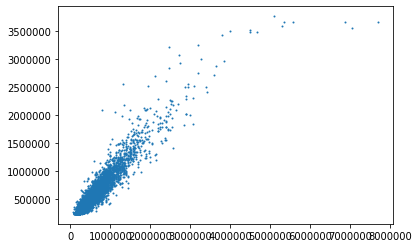

In [27]:
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_train[pred_train>df_train['price'].max()]=df_train['price'].max()
pred_train[pred_train<df_train['price'].min()]=df_train['price'].min()

print('MSE is:',np.sqrt(mse(y_train,pred_train)))
print('R2 is:',r2_score(y_train,pred_train))

plt.scatter(y_train, pred_train, s=1)
plt.show()

In [34]:
scores=cross_val_score(reg, X=X_train, y=y_train, cv=5,scoring='r2')
print(scores)
print('cv_mean:', round(scores.mean(), 2))
print('cv_std:', round(scores.std(), 2))

[0.82312697 0.81221336 0.82770454 0.81789721 0.82568274]
cv_mean: 0.82
cv_std: 0.01


#### Define the parameters for Grid seach and then conduct the grid search 

In [36]:
gridparam={
    'num_leaves':[30,50],
    'boosting_type':['gbdt','dart'],
    'learning_rate':[0.1,0.01],
    'n_estimators':[25,50,75],
    'subsample':[0.5,0.7,0.9],
    'colsample_bytree':[0.8,0.9],
    'reg_alpha':[0,5,10],
    'reg_lambda':[0,5,10] 
    }

In [37]:
grid = GridSearchCV(reg, gridparam, cv=4, verbose=1)
grid.fit(X_train,y_train)

Fitting 4 folds for each of 1296 candidates, totalling 5184 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed: 10.7min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=0.8,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.1,
                                     n_estimators=25, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=5, reg_lambda=5, silent=T...
                                     subsample=0.6, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.01],
      

In [38]:
print(grid.best_score_)
print(grid.best_params_)

0.8710920736366728
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 75, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.5}


#### Rewrite the LGBM regressor based on the best parameters found by the grid search 

In [39]:
reg2=lgbm.LGBMRegressor(
    objective='regression',
    boosting_type=grid.best_params_['boosting_type'],
    learning_rate=grid.best_params_['learning_rate'],
    num_leaves=grid.best_params_['num_leaves'],
    n_estimators=grid.best_params_['n_estimators'],
    min_split_gain=0.1,
    subsample=grid.best_params_['subsample'],
    colsample_bytree=grid.best_params_['colsample_bytree'],
    reg_alpha=grid.best_params_['reg_alpha'],
    reg_lambda=grid.best_params_['reg_lambda'],
    )

MSE is: 93248.43292479575
R2 is: 0.9388294567302643


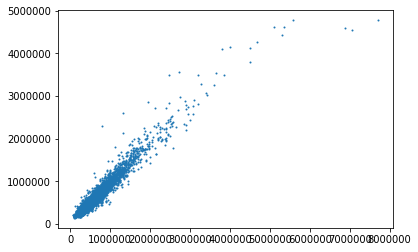

In [40]:
reg2.fit(X_train, y_train)
pred_train2 = reg2.predict(X_train)

pred_train2[pred_train2>df_train['price'].max()]=df_train['price'].max()
pred_train2[pred_train2<df_train['price'].min()]=df_train['price'].min()

print('MSE is:',np.sqrt(mse(y_train,pred_train2)))
print('R2 is:',r2_score(y_train,pred_train2))

plt.scatter(y_train, pred_train2, s=1)

In [41]:
scores2=cross_val_score(reg2, X=X_train, y=y_train, cv=5,scoring='r2')
print(scores2)
print('cv_mean:', round(scores2.mean(), 2))
print('cv_std:', round(scores2.std(), 2))

[0.87478198 0.84660126 0.86157945 0.8702947  0.87390731]
cv_mean: 0.87
cv_std: 0.01


#### What is the purpose of lgbm.train functions?

In [43]:
params = {
    'application': 'regression', 
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 1000, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'rmse',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 0.8, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

In [45]:
X_tm, X_vl, y_tm, y_vl = train_test_split(X_train, y_train, test_size=0.2)
d_tm = lgbm.Dataset(X_tm, label=y_tm)
d_vl = lgbm.Dataset(X_vl, label=y_vl)
model=lgbm.train(params, train_set=d_tm, num_boost_round=1000, valid_sets=d_vl, early_stopping_rounds=50, verbose_eval=4)

Training until validation scores don't improve for 50 rounds
[4]	valid_0's rmse: 346672
[8]	valid_0's rmse: 313050
[12]	valid_0's rmse: 282188
[16]	valid_0's rmse: 257632
[20]	valid_0's rmse: 236999
[24]	valid_0's rmse: 219379
[28]	valid_0's rmse: 206385
[32]	valid_0's rmse: 193862
[36]	valid_0's rmse: 182967
[40]	valid_0's rmse: 172922
[44]	valid_0's rmse: 164961
[48]	valid_0's rmse: 158613
[52]	valid_0's rmse: 153292
[56]	valid_0's rmse: 149275
[60]	valid_0's rmse: 146132
[64]	valid_0's rmse: 142885
[68]	valid_0's rmse: 140183
[72]	valid_0's rmse: 137852
[76]	valid_0's rmse: 136306
[80]	valid_0's rmse: 134495
[84]	valid_0's rmse: 133182
[88]	valid_0's rmse: 131564
[92]	valid_0's rmse: 130155
[96]	valid_0's rmse: 129004
[100]	valid_0's rmse: 128401
[104]	valid_0's rmse: 127632
[108]	valid_0's rmse: 127117
[112]	valid_0's rmse: 126671
[116]	valid_0's rmse: 126000
[120]	valid_0's rmse: 125733
[124]	valid_0's rmse: 125274
[128]	valid_0's rmse: 124984
[132]	valid_0's rmse: 124711
[136]	va

#### Decision Tree Regressor

MSE is: 164022.99989821206
R2 is: 0.8107356773625323


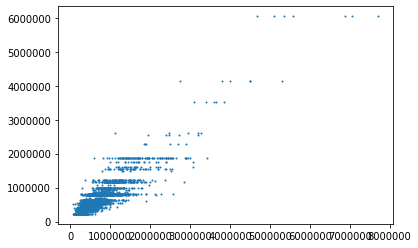

In [52]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=5)
dt.fit(X_train, y_train)

pred_train3 = dt.predict(X_train)

pred_train3[pred_train3>df_train['price'].max()]=df_train['price'].max()
pred_train3[pred_train3<df_train['price'].min()]=df_train['price'].min()

print('MSE is:',np.sqrt(mse(y_train,pred_train3)))
print('R2 is:',r2_score(y_train,pred_train3))

plt.scatter(y_train, pred_train3, s=1)

#### Use Stacking Regressor with Linear Regression as the final regressor 

MSE is: 91975.76173257378
R2 is: 0.9404877952259626


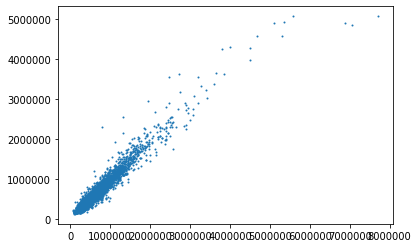

In [53]:
estimators = [('lbgm', reg2),('dt', dt)]

reg_sr = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
reg_sr.fit(X_train, y_train)

pred_train4 = reg_sr.predict(X_train)

pred_train4[pred_train4>df_train['price'].max()]=df_train['price'].max()
pred_train4[pred_train4<df_train['price'].min()]=df_train['price'].min()

print('MSE is:',np.sqrt(mse(y_train,pred_train4)))
print('R2 is:',r2_score(y_train,pred_train4))

plt.scatter(y_train, pred_train4, s=1)

# 

In [54]:
scores4=cross_val_score(reg_sr, X=X_train, y=y_train, cv=5,scoring='r2')
print(scores4)
print('cv_mean:', round(scores4.mean(), 2))
print('cv_std:', round(scores4.std(), 2))

[0.87431792 0.85188674 0.84510185 0.87539498 0.88235254]
cv_mean: 0.87
cv_std: 0.01


#### Predict the house price for test data 

In [50]:
df_test = pd.read_csv("../Data/House Price Prediction/test.csv")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month

X_test = df_test.drop(['id', 'date'], axis=1)

pred_test = reg2.predict(X_test)
df_test['price'] = pred_test

df_test.to_csv('test_HP_lgbm.csv')